In [1]:
# Import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
import random
from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter

d:\Mathematics\2021-2022\Deep Learning in Scientific Computing\Projects\Project1\Project1\Parte 1\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
class NeuralNet(nn.Module):

    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 neurons,
                 regularization_param,
                 regularization_exp,
                 retrain_seed,
                 activation_name):

        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation_name = activation_name
        self.activation = self.get_activation(activation_name)
        # Regularization parameter
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization
        self.retrain_seed = retrain_seed

        if self.n_hidden_layers != 0:
            self.input_layer = nn.Linear(self.input_dimension, self.neurons)
            self.hidden_layers = nn.ModuleList(
                [nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
            self.output_layer = nn.Linear(self.neurons, self.output_dimension)

        else:
            print("Simple linear regression")
            self.linear_regression_layer = nn.Linear(self.input_dimension, self.output_dimension)

        self.init_xavier()

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                if self.activation_name in ['tanh', 'relu']:
                    gain = nn.init.calculate_gain(self.activation_name)
                else:
                    gain = 1
                torch.nn.init.xavier_uniform_(m.weight, gain=gain)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return reg_loss

    def get_activation(self, activation_name):
        if activation_name in ['tanh']:
            return nn.Tanh()
        elif activation_name in ['relu']:
            return nn.ReLU(inplace=True)
        elif activation_name in ['lrelu']:
            return nn.LeakyReLU(inplace=True)
        elif activation_name in ['sigmoid']:
            return nn.Sigmoid()
        elif activation_name in ['softplus']:
            return nn.Softplus(beta=4)
        elif activation_name in ['celu']:
            return nn.CELU()
        else:
            raise ValueError('Unknown activation function')

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        if self.n_hidden_layers != 0:
            x = self.activation(self.input_layer(x))
            for k, l in enumerate(self.hidden_layers):
                x = self.activation(l(x))
            return self.output_layer(x)
        else:
            return self.linear_regression_layer(x)

In [4]:
def run_single_configuration(conf_dict, x_, y_):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    print(conf_dict)

    # Get the configuration to test
    opt_type = conf_dict["optimizer"]
    n_epochs = conf_dict["epochs"]
    n_hidden_layers = conf_dict["hidden_layers"]
    neurons = conf_dict["neurons"]
    regularization_param = conf_dict["regularization_param"]
    regularization_exp = conf_dict["regularization_exp"]
    retrain_seed = conf_dict["init_weight_seed"]
    batch_size = conf_dict["batch_size"]
    activation = conf_dict["activation"]

    validation_size = int(0 * x_.shape[0] / 100)
    training_size = x_.shape[0] - validation_size
    x_train = x_[:training_size, :]
    y_train = y_[:training_size, :]

    x_val = x_[training_size:, :]
    y_val = y_[training_size:, :]

    training_set = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    my_network = NeuralNet(input_dimension=x_.shape[1],
                           output_dimension=y_.shape[1],
                           n_hidden_layers=n_hidden_layers,
                           neurons=neurons,
                           regularization_param=regularization_param,
                           regularization_exp=regularization_exp,
                           retrain_seed=retrain_seed,
                           activation_name=activation)

    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    history = fit(my_network, training_set, x_val, y_val, n_epochs, optimizer_, p=2, verbose=False)

    y_val = y_val.reshape(-1, )
    y_train = y_train.reshape(-1, )

    #y_test_pred = my_network(x_test).reshape(-1, )
    y_val_pred = my_network(x_val).reshape(-1, )
    y_train_pred = my_network(x_train).reshape(-1, )

    # Compute the relative training error
    relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
    print("Relative Training Error: ", relative_error_train.detach().numpy() ** 0.5 * 100, "%")

    # Compute the relative validation error
    relative_error_val = torch.mean((y_val_pred - y_val) ** 2) / torch.mean(y_val ** 2)
    print("Relative Validation Error: ", relative_error_val.detach().numpy() ** 0.5 * 100, "%")

    return relative_error_train.item(), relative_error_val.item(), my_network

In [5]:
def fit(model, training_set, x_validation_, y_validation_, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    regularization_param = model.regularization_param

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                loss_u = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p)
                loss_reg = model.regularization()
                loss = loss_u + regularization_param * loss_reg
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item() / len(training_set)
                return loss

            optimizer.step(closure=closure)

        y_validation_pred_ = model(x_validation_)
        validation_loss = torch.mean((y_validation_pred_.reshape(-1, ) - y_validation_.reshape(-1, )) ** p).item()
        history[0].append(running_loss[0])
        history[1].append(validation_loss)

        if verbose:
            print('Training Loss: ', np.round(running_loss[0], 8))
            print('Validation Loss: ', np.round(validation_loss, 8))

    print('Final Training Loss: ', np.round(history[0][-1], 8))
    print('Final Validation Loss: ', np.round(history[1][-1], 8))
    return history

LOAD THE DATA

In [3]:
data = np.loadtxt("TrainingData.txt", delimiter=',', skiprows=1)
t = data[:,0]
Tf0 = data[:,1]
Ts0 = data[:,2]

minima = []
maxima = []
means = []
stds = []
for i in range(3):
    means.append((np.mean(data[:,i])))
    stds.append((np.std(data[:,i])))
    minima.append(min(data[:,i]))
    maxima.append(max(data[:,i]))

t_trainmm = (t - minima[0])/(maxima[0] - minima[0])
Tf0_trainmm = (Tf0 - minima[1])/(maxima[1] - minima[1])
Ts0_trainmm = (Ts0 - minima[2])/(maxima[2] - minima[2])

t_trainnorm = (t - means[0])/stds[0]
Tf0_trainnorm = (Tf0 - means[1])/stds[1]
Ts0_trainnorm = (Ts0 - means[2])/stds[2]


# TO VALIDATE
data3 = np.loadtxt("TrainingData3.txt", delimiter = ',', skiprows=1)
t3 = data3[:,0]
Ts03 = data3[:,2]
Tf03= data3[:, 1]
t3_prednorm =(t3 - means[0])/stds[0]
Tf03_predmm = (Tf03 - minima[1])/(maxima[1] - minima[1])

DENOISING OF THE DATASET FOR TF0

In [4]:
high_data = []
#0 is Ts0

for i in range(len(t)):
    if Ts0[i] > 860:
        high_data.append([t[i], Ts0[i],  0])
    if Tf0[i] > 860:
        high_data.append([t[i], Tf0[i], 1])

high_data = np.array(high_data)

In [5]:
mean = np.mean(high_data[:,1])
assemble_new = []
for i in range(high_data.shape[0]):
    scarto = high_data[i,1] - mean
    new_scarto = scarto/100
    assemble_new.append([high_data[i,0], mean + new_scarto, high_data[i,2]])

assemble_new = np.array((assemble_new))

In [6]:
Tf0_denoisy = np.copy(Tf0)
print(Tf0_denoisy.shape)
index = np.where(assemble_new[:,2] == 1)
count = 0
print("index", len(index[0]))
for i in index[0]:
    for j in range(len(t)):
        if abs(assemble_new[i,0] - t[j]) < 1e-5:
            Tf0_denoisy[j] = assemble_new[i,1]
            count += 1

print("count", count)

(265,)
index 141
count 141


FIT A FIRST NN

In [7]:
Tf0_denoisy_trainnorm=(Tf0_denoisy- means[1])/stds[1]
Tf0_denoisy_trainmm=(Tf0_denoisy-minima[1])/(maxima[1]-minima[1])

In [11]:
hyperparameters_configurations = {
        "hidden_layers": [2],
        "neurons": [25, 30],
        "regularization_exp": [2],
        "regularization_param": [0],
        "batch_size": [5, 30],
        "epochs": [10000],
        "optimizer": ["ADAM"],
        "init_weight_seed": [365, 3000],
        "activation": ["tanh"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

my_networks = list()
train_err_conf = list()
val_err_conf = list()
for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_net = run_single_configuration(setup_properties, torch.from_numpy(t_trainmm.reshape(-1,1)).type(torch.float32), torch.from_numpy(Tf0_denoisy_trainmm).reshape(-1,1).type(torch.float32))
    train_err_conf.append(relative_error_train_)
    val_err_conf.append(relative_error_val_)
    my_networks.append(my_net)

train_err_conf = np.array(train_err_conf)
val_err_conf = np.array(val_err_conf)
my_networks = np.array(my_networks)

################################### 0 ###################################
{'hidden_layers': 2, 'neurons': 25, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 5, 'epochs': 10000, 'optimizer': 'ADAM', 'init_weight_seed': 365, 'activation': 'tanh'}
Final Training Loss:  0.01357578
Final Validation Loss:  nan
Relative Training Error:  15.118850767612457 %
Relative Validation Error:  nan %
################################### 1 ###################################
{'hidden_layers': 2, 'neurons': 25, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 5, 'epochs': 10000, 'optimizer': 'ADAM', 'init_weight_seed': 3000, 'activation': 'tanh'}
Final Training Loss:  0.00602708
Final Validation Loss:  nan
Relative Training Error:  8.942358940839767 %
Relative Validation Error:  nan %
################################### 2 ###################################
{'hidden_layers': 2, 'neurons': 25, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 30, 'epochs'

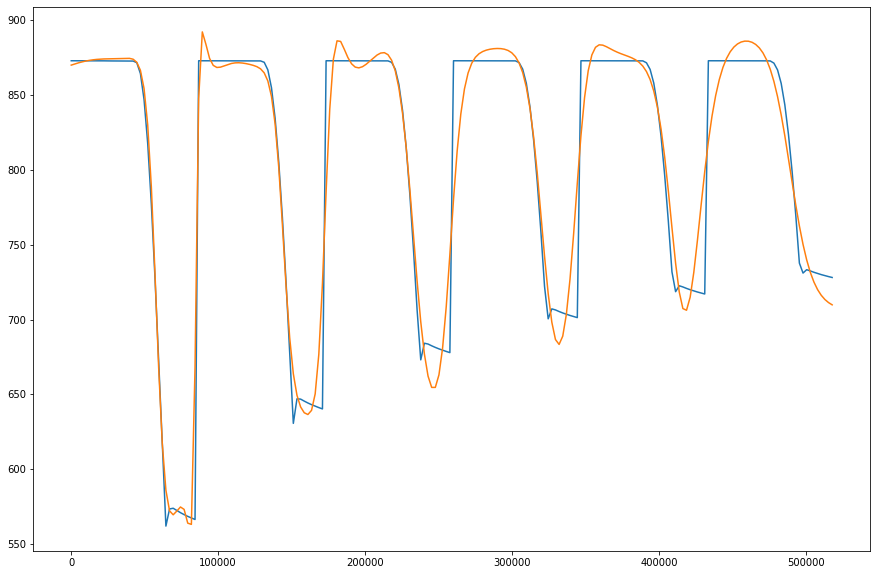

In [14]:
t3_train=(t3-minima[0])/(maxima[0]-minima[0])
y_pred=my_networks[7](torch.from_numpy(t3_train.reshape(-1,1)).type(torch.float32))*(maxima[1]-minima[1])+minima[1]
plt.figure(figsize=(15,10))
plt.plot(t3, Tf03)
plt.plot(t3,y_pred.detach().numpy())

In [27]:
x_3 = (t3[4:]-minima[0])/(maxima[0]-minima[0])
y_pred=my_networks[16](torch.from_numpy(x_3.reshape(-1,1)).type(torch.float32))*(maxima[1]-minima[1])+minima[1]
y_3 = (Tf03[4:])#-meany)/stdy

print('noiseless error: ',(np.mean((y_pred.detach().numpy()-y_3)**2)/np.mean(y_3**2))**0.5*100)

noiseless error:  16.01544237210056


XGBoost 

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

train_set1 = pd.DataFrame({'t':t_trainnorm,'ts0':Tf0_denoisy_trainnorm})



In [9]:
X, y = train_set1.iloc[:,:-1],train_set1.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.3, subsample = 1,
                max_depth = 5, gamma = 0, alpha = 0.25, reg_lambda = 3, n_estimators = 100)


In [10]:
xg_reg.fit(X,y)
preds = xg_reg.predict(X)

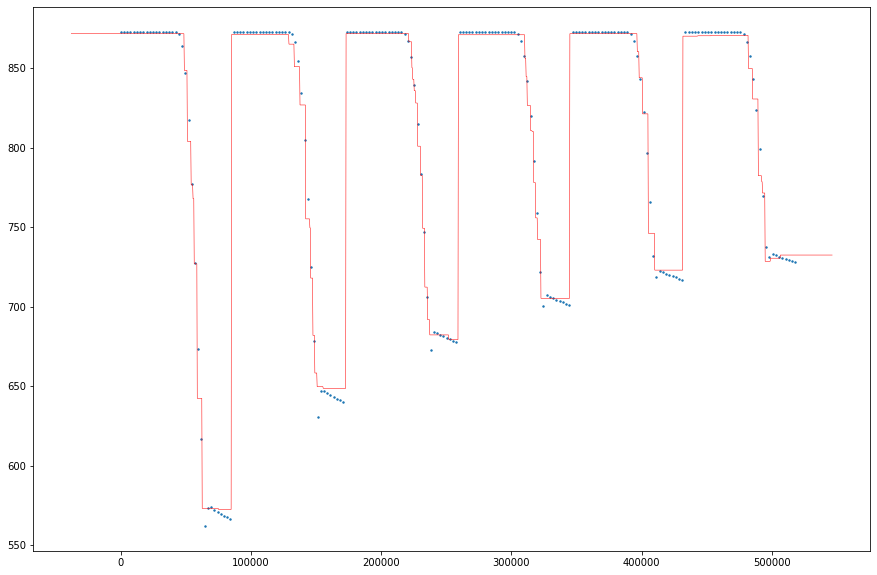

In [13]:
x_lin = np.linspace(-2,2,2000)
x_lin_pd = pd.DataFrame({'t':x_lin})
pred_x_lin = xg_reg.predict(x_lin_pd)
pred_x_lin = pred_x_lin*stds[1]+means[1]
plt.figure(figsize=(15, 10))
plt.scatter(data3[:,0],data3[:,1],s=2)
plt.plot(x_lin*stds[0]+means[0],pred_x_lin,c='r',linewidth=.5)
plt.show()

In [11]:
x_3 = (data3[:,0]-means[0])/stds[0]
y_3 = (data3[:,1])#-meany)/stdy
newdata1 = pd.DataFrame({'t':x_3,'ts0':y_3})
X, y = newdata1.iloc[:,:-1],newdata1.iloc[:,-1]
# Saving feature names for later use
feature_list = list(X.columns)
# Convert to numpy array
features = np.array(X)
preds = xg_reg.predict(features)
preds = preds*stds[1]+means[1]


print('noiseless error: ',(np.mean((preds-y)**2)/np.mean(y**2))**0.5*100)


noiseless error:  0.7480808573294901


LET'S MAKE AN ENSEMBLE

In [18]:
def get_prediction(X, Xtorch):
    features = np.array(X)
    predxg = xg_reg.predict(features)*stds[1]+means[1]
    predxg = savgol_filter(predxg, 200, 1)
    predxg = torch.from_numpy(predxg).unsqueeze(1)
    #predGP = GPonlyx.predict(Xtorch.float())[0]*stdy1+meany1 #NB: in this code model is just the GP!
    #predGP=torch.from_numpy(predGP).unsqueeze(1)
    #predNN = my_net(Xtorch.float()) * (maxima[1]-minima[1])+minima[1]  # NB: in this code model is just the GP!
    #predNN=(predNN).unsqueeze(1)
    return 1*predxg 

In [15]:
#PREDICTIONS ON THE TEST SET with ensemble
testdata = "TestingData.txt"
testdata = pd.read_csv(testdata)
testdata1 = testdata.to_numpy()


In [16]:
(testdata1.squeeze()).shape

(18886,)

d:\Mathematics\2021-2022\Deep Learning in Scientific Computing\Projects\Project1\Project1\Parte 1\.venv\lib\site-packages\torch\_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


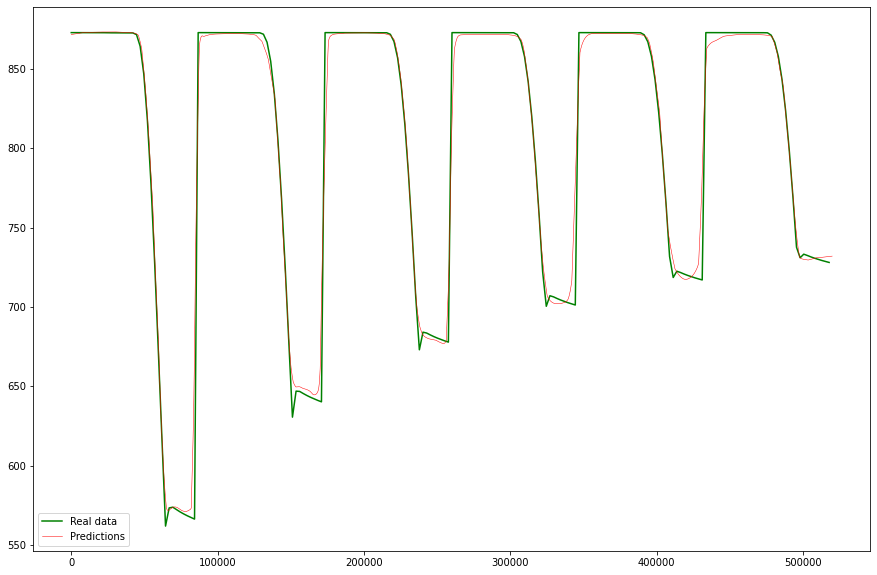

In [19]:
x_trainnorm = (testdata1.squeeze()-means[0])/stds[0]
x_trainmm = (testdata1.reshape(-1, 1)-minima[0])/(maxima[0]-minima[0])

x = x_trainnorm
trainfake1 = pd.DataFrame({'t':x})
x=torch.from_numpy(np.asarray(x_trainmm)).reshape(-1,1)

#X = (testdata.iloc[:,0]-meanx)/stdx #,newdata1.iloc[:,-1]
y_pred = get_prediction(trainfake1,x).reshape(-1,1)

x = torch.from_numpy(testdata1)
x = (x.resize(18886,1)).reshape(-1,1).detach().numpy()
#print(x)
#print(y_pred)
#plt.plot(x*stdx+meanx, y_pred, c='r', label="y true",linewidth=0.5)#,linewidth=.5)
plt.figure(figsize=(15, 10))
plt.plot(data3[:, 0], data3[:,1], c="g", label="Real data")
plt.plot(x, y_pred.detach().numpy(), c='r', label="Predictions",linewidth=0.5)#,linewidth=.5)
plt.legend()
plt.show()

In [18]:
def get_prediction(X, alpha):
    features = np.array(X)
    predxg = xg_reg.predict(features)*stds[1]+means[1]
    predxg = savgol_filter(predxg, 200, 1)
    predxg = torch.from_numpy(predxg).unsqueeze(1)
    #Xtorch = torch.from_numpy(X)
    #predGP = GPonlyx.predict(Xtorch.float())[0]*stdy1+meany1 #NB: in this code model is just the GP!
    #predGP=torch.from_numpy(predGP).unsqueeze(1)
    #predNN = my_net(Xtorch.float()) * (maxima[1]-minima[1])+minima[1]  # NB: in this code model is just the GP!
    #predNN=(predNN).unsqueeze(1)
    return predxg #alpha*predxg+(1-alpha)*prednn #0.55,0.45


from sklearn.ensemble import RandomForestRegressor

RF3=RandomForestRegressor()
R3=RF3.fit(t3.reshape(-1,1), Tf03)
pred_test=R3.predict(testdata1).reshape(-1,1)

x_trainnorm = (testdata1.squeeze()-means[0])/stds[0]
x_trainmm = (testdata1.reshape(-1, 1)-minima[0])/(maxima[0]-minima[0])

x = x_trainnorm
trainfake1 = pd.DataFrame({'t':x})
x=torch.from_numpy(np.asarray(x_trainmm)).reshape(-1,1)
error=[]
for x in np.linspace(0,1, 100):
    y_pred = get_prediction(trainfake1,x).reshape(-1,1)
    error.append([np.sqrt(np.mean((y_pred.detach().numpy()-pred_test)**2)/np.mean(pred_test**2))*100, x])
    
    
#print(error[error.index(min(error[:, 0]))])





In [20]:
from sklearn.ensemble import RandomForestRegressor

RF3=RandomForestRegressor()
R3=RF3.fit(t3.reshape(-1,1), Tf03)
pred_test=R3.predict(testdata1).reshape(-1,1)

In [21]:
print(np.sqrt(np.mean((y_pred.detach().numpy()-pred_test)**2)/np.mean(pred_test**2))*100)

0.9569181005699345
